# Stack the IMOS mooring data from the AODN S3 bucket

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from s3fs import S3FileSystem, S3Map

In [2]:
# Access the AODN s3 bucket like this
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data')
for item in aodn:
    print(item)


imos-data/Bureau_of_Meteorology
imos-data/CSIRO
imos-data/Deakin_University
imos-data/Defence_Technology_Agency-New_Zealand
imos-data/Department_of_Defence
imos-data/Department_of_Environment_and_Science-Queensland
imos-data/Department_of_Transport-Western_Australia
imos-data/Derwent_Estuary_Program
imos-data/Future_Reef_MAP
imos-data/IMOS
imos-data/Macquarie_University
imos-data/NSW-OEH
imos-data/TERN
imos-data/UNSW
imos-data/UWA
imos-data/WAMSI
imos-data/error.html
imos-data/index.html
imos-data/robots.txt


In [3]:
# Function that combines the steps above to return a QC'd variable as a DataArray object
def get_temp_qc_aodn(filename,varname='TEMP'):
    fileobj = fs.open(filename)
    ds = xr.open_dataset(fileobj)
    badidx = ds['{}_quality_control'.format(varname)].values !=1
    temp = ds['{}'.format(varname)]
    temp[badidx] = np.nan
    return temp

def get_timerange(tempfiles,freq='60s'):
    # Get the min and max time steps
    t0 = np.datetime64('2100-01-01')
    t1 = np.datetime64('1900-01-01')
    for tempfile in tempfiles:
        fileobj = fs.open(tempfile)
        ds = xr.open_dataset(fileobj)
        if ds.TIME.values[0] < t0:
            t0 = ds.TIME.values[0]
        if ds.TIME.values[-1] > t1:
            t1 = ds.TIME.values[-1]

        #print(ds.TIME.values[0], ds.TIME.values[-1], ds.TIME.shape)
        time = pd.date_range(t0,t1, freq=freq).values
    
    return time

In [6]:
def get_tempfiles_aodn(sitename, timestr, dirnames = ['Temperature','CTD_timeseries']):
    """
    Return a list of all netcdf files in the folder dirnames
    """
    files = []
    for fpath in dirnames:
        aodn = fs.glob('imos-data/IMOS/ANMN/QLD/{}/{}/*TZ_{}*.nc'.format(sitename, fpath, timestr))
        for item in aodn:
            files.append(item)
    return files

# for ss in sites:
#     for t1 in ss['timestart']
get_tempfiles_aodn('NWSBAR','20')

['imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE39-37.7_END-20200218T002000Z_C-20200312T052514Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE39-57.7_END-20200218T002000Z_C-20200312T052506Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE39plus-132.7_END-20200218T002000Z_C-20200312T052447Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE56-117.7_END-20200218T002000Z_C-20200312T052451Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE56-12.7_END-20200218T002000Z_C-20200312T052525Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temperature/IMOS_ANMN-QLD_TZ_20190806T021500Z_NWSBAR_FV01_NWSBAR-1907-SBE56-157.7_END-20200218T002000Z_C-20200312T052427Z.nc',
 'imos-data/IMOS/ANMN/QLD/NWSBAR/Temper

In [8]:
# Create a dictionary of site names and deployment start times
sites = {
    #'PIL200':{'timestart':['201202','201208','201302','201308','201402']},
    #'KIM200':{'timestart':['201202','201208','201301','201307','201401']},
    #'KIM400':{'timestart':['201202','20120[7-8]','201301','201307','201401']},
    #'ITFTIS':{'timestart':['201201','201207','201212','201306','201401',
    #                      '201409','201502','201508','201602','201607',
    #                      '201702','201707','201802','201808']},
    'NWSROW':{'timestart':['201908']},
    'NWSBRW':{'timestart':['201907']},
    'NWSBAR':{'timestart':['201908']},
}

In [9]:
# Get all of the files for one site
# for ss in sites:
#     for t1 in ss['timestart']


In [10]:
def stack_mooring_var(tempfiles, time, varname='TEMP', VERBOSE=False):
    alltemp = None
    for tempfile in tempfiles:
        if VERBOSE:
            print(tempfile)

        if alltemp is None:
            temp = get_temp_qc_aodn(tempfile)
            alltemp = temp.interp(TIME=time)
        else:
            temp = get_temp_qc_aodn(tempfile, varname=varname)

            # Print out the time information for each file (this is helpful to choose the time vector above...)

            dt = temp.TIME[1] - temp.TIME[0]
            if VERBOSE:
                print(temp.TIME.values[0], temp.TIME.values[-1], temp.TIME.shape)
                print(alltemp.TIME.values[0], alltemp.TIME.values[-1], alltemp.TIME.shape)
                print(dt.values.astype('timedelta64[s]'))

            # Interpolation step
            temp_i = temp.interp(TIME=time)

            # Check for too many missing values...
            if np.all(np.isnan(temp_i)):
                print('Skipping file... all bad data!!')
                continue

            # Stack the vector onto the main array
            alltemp = xr.concat([alltemp,temp_i], dim='NOMINAL_DEPTH', join='exact')
    
    # Return a sorted array
    return alltemp.sortby(['NOMINAL_DEPTH'])

            


In [11]:
# Remove bad rows
def salt_qc(T):
    'quality control salinity array'
    Tmean = T.mean(axis=1).values
    badrow = (Tmean < 32) | (Tmean>38)
    return T.drop_sel({'NOMINAL_DEPTH':T.NOMINAL_DEPTH[badrow]})

def depth_qc(T):
    """Quality control and pressure array by removing inversions"""
    Tmean = T.mean(axis=1).values
    badrow = np.zeros_like(Tmean, dtype=np.bool)
    badrow[1::] = np.diff(Tmean) < 0.
    return T.drop_sel({'NOMINAL_DEPTH':T.NOMINAL_DEPTH[badrow]})
    
def temp_qc(T):
    """Quality control and pressure array by removing inversions"""
    Tmean = T.mean(axis=1).values
    badrow = np.zeros_like(Tmean, dtype=np.bool)
    badrow[1::] = np.diff(Tmean) > 0.
    return T.drop_sel({'NOMINAL_DEPTH':T.NOMINAL_DEPTH[badrow]})

def qc(T, varname):
    if varname == 'TEMP':
        return temp_qc(T)
    elif varname == 'PSAL':
        return salt_qc(T)
    elif varname == 'DEPTH':
        return depth_qc(T)

########################################################################
NWSROW 201908 TEMP
Found 16 files...
Getting time range...
2019-07-27T00:00:00.000000000 2020-02-17T02:09:00.000000000
Skipping file... all bad data!!
Saved data to:  C:\Users\mrayson\cloudstor\Data\IMOS\AODN\IMOS_Stack_Mooring_NWSROW_201908_TEMP_60s.nc
########################################################################
NWSROW 201908 PSAL
Found 4 files...
Getting time range...
2019-07-28T00:00:01.000004608 2020-02-17T02:09:01.000004608
Skipping file... all bad data!!
Saved data to:  C:\Users\mrayson\cloudstor\Data\IMOS\AODN\IMOS_Stack_Mooring_NWSROW_201908_PSAL_60s.nc
########################################################################
NWSROW 201908 DEPTH
Found 4 files...
Getting time range...
2019-07-28T00:00:01.000004608 2020-02-17T02:09:01.000004608
Saved data to:  C:\Users\mrayson\cloudstor\Data\IMOS\AODN\IMOS_Stack_Mooring_NWSROW_201908_DEPTH_60s.nc
###################################################

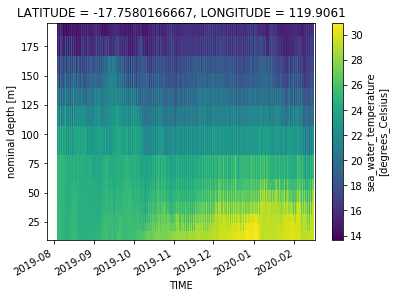

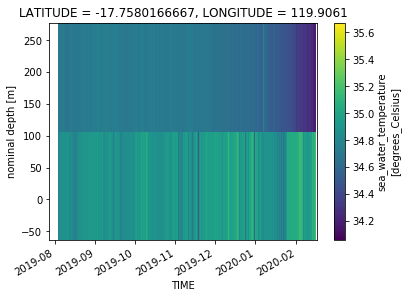

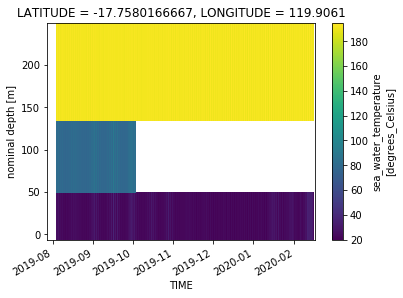

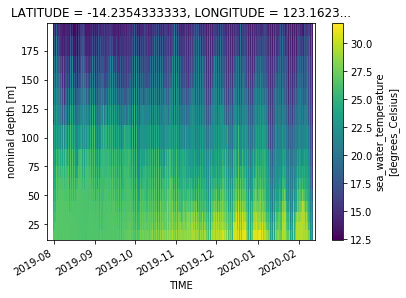

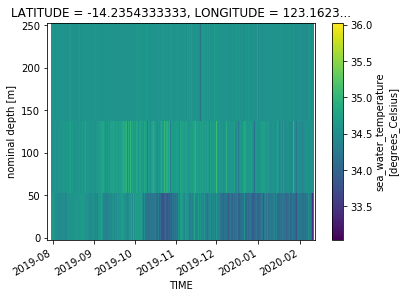

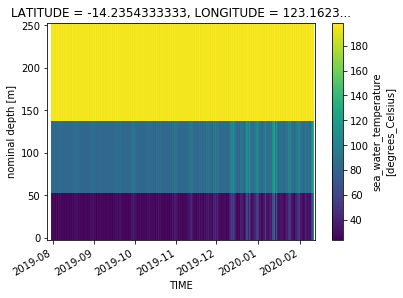

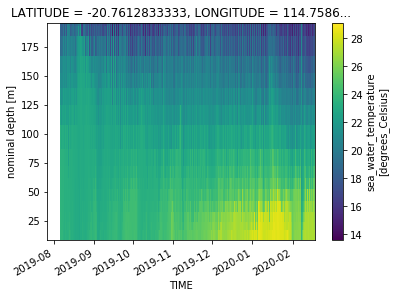

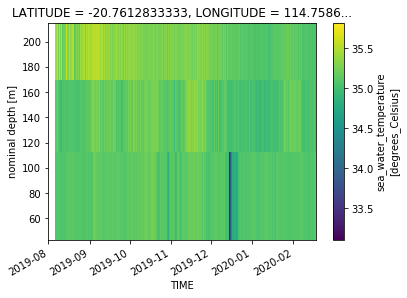

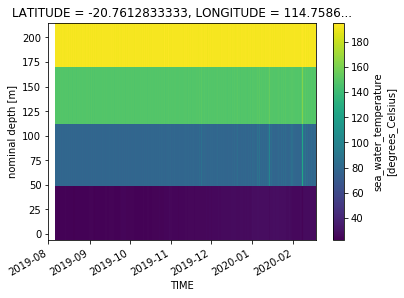

In [12]:
# Get the files
outpath = r'C:\Users\mrayson\cloudstor\Data\IMOS\AODN'
varnames = ['TEMP','PSAL','DEPTH']


for ss in sites:
    for tstart in sites[ss]['timestart']:
        for varname in varnames:
            print(72*'#')
            print(ss, tstart, varname)
            if varname in ['PSAL','DEPTH']:
                dirnames = ['CTD_timeseries']
            else:
                dirnames =['Temperature','CTD_timeseries']

            Tfiles = get_tempfiles_aodn(ss,tstart, dirnames=dirnames)
            print('Found {} files...'.format(len(Tfiles)))
            # Get the time range
            print('Getting time range...')
            time = get_timerange(Tfiles)
            print(time[0],time[-1])
            # Stack
            T = stack_mooring_var(Tfiles, time, varname=varname, VERBOSE=False)

            # QC
            T_qc = qc(T, varname)

            outfile = '{}\IMOS_Stack_Mooring_{}_{}_{}_60s.nc'.format(outpath, ss, tstart, varname)
            T_qc.to_netcdf(outfile)
            
            fig = plt.figure()
            T_qc.plot()
            outfilefig = '{}\IMOS_Stack_Mooring_{}_{}_{}_60s.png'.format(outpath, ss, tstart, varname)
            plt.savefig(outfilefig,dpi=150)
            del fig
            print('Saved data to: ',outfile)


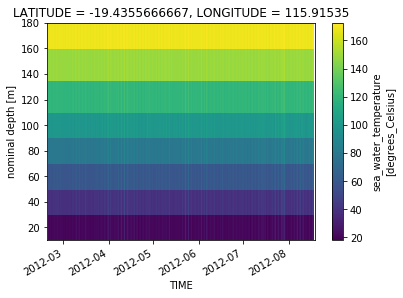

In [90]:
T_qc.plot()
#T.NOMINAL_DEPTH[badrow]

In [34]:
# Try  pressure and salinity
Pfiles = get_tempfiles_aodn('PIL200','201202', dirnames=['CTD_timeseries'])
print('Found {} files...'.format(len(Pfiles)))
# Get the time range
print('Getting time range...')
time = get_timerange(Pfiles)
print(time[0],time[-1])

# Stack
P = stack_mooring_var(Pfiles, time, varname='PSAL', VERBOSE=True)


Found 9 files...
Getting time range...
2012-02-19T03:50:00.999996928 2012-08-19T00:52:00.999996928
imos-data/IMOS/ANMN/QLD/PIL200/CTD_timeseries/IMOS_ANMN-QLD_CSTZ_20120219T035001Z_PIL200_FV01_PIL200-1202-SBE37SM-RS232-195_END-20120818T154701Z_C-20170620T005835Z.nc
imos-data/IMOS/ANMN/QLD/PIL200/CTD_timeseries/IMOS_ANMN-QLD_CSTZ_20120220T000001Z_PIL200_FV01_PIL200-1202-SBE37SM-RS232-100_END-20120818T115101Z_C-20170620T005906Z.nc
2012-02-20T00:00:01.000004608 2012-08-18T11:51:00.999996672 (259912,)
2012-02-19T03:50:00.999996928 2012-08-19T00:52:00.999996928 (261903,)
59 seconds
imos-data/IMOS/ANMN/QLD/PIL200/CTD_timeseries/IMOS_ANMN-QLD_CSTZ_20120220T000001Z_PIL200_FV01_PIL200-1202-SBE37SM-RS232-120_END-20120818T160701Z_C-20170620T005901Z.nc
2012-02-20T00:00:01.000004608 2012-08-18T16:07:00.999996416 (260168,)
2012-02-19T03:50:00.999996928 2012-08-19T00:52:00.999996928 (261903,)
59 seconds
imos-data/IMOS/ANMN/QLD/PIL200/CTD_timeseries/IMOS_ANMN-QLD_CSTZ_20120220T000001Z_PIL200_FV01_PIL2

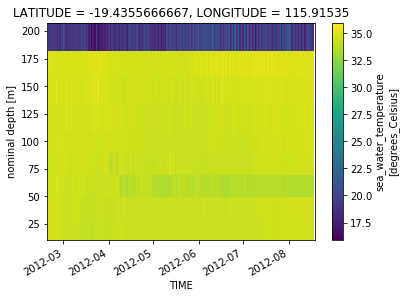

In [35]:
plt.figure()
P.plot()

In [50]:
T

<xarray.DataArray 'TEMP' (NOMINAL_DEPTH: 9, TIME: 261903)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    LATITUDE       float64 -19.44
    LONGITUDE      float64 115.9
  * TIME           (TIME) datetime64[ns] 2012-02-19T03:50:00.999996928 ... 2012-08-19T00:52:00.999996928
  * NOMINAL_DEPTH  (NOMINAL_DEPTH) float64 20.0 40.0 60.0 ... 150.0 170.0 195.0
Attributes:
    ancillary_variables:  TEMP_quality_control
    long_name:            sea_water_temperature
    standard_name:        sea_water_temperature
    units:                degrees_Celsius
    valid_max:            [40.]
    valid_min:            [-2.5]